# `eeg-03`: Spectral analysis
This demo introduces time-frequency analysis of EEG data using MNE. We'll start by loading the epoched data from the previous notebook.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook', font_scale=1.25)
%matplotlib inline

Today's demonstration will introduce time-frequency analysis of EEG data using MNE. We will start by loading the epoched data from last session.

In [2]:
from mne import read_epochs

# Load epoched data
f = '../eeg-data/sub-01_task-audvis-epo.fif'
epochs = read_epochs(f, preload=True, verbose=False)

### Frequency analysis

As a rough first-pass, we can look at the frequency composition, collapsing across time, over the scalp topography. We use the the `plot_psd_topomap` method of the MNE's `Epochs` class to plot the power spectral density across epochs.

left visual stimuli


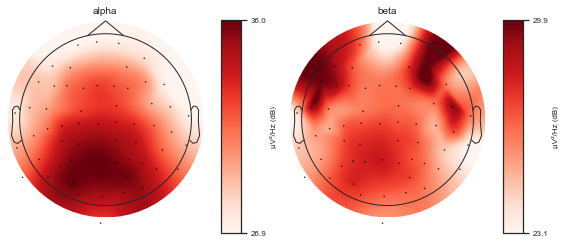

right visual stimuli


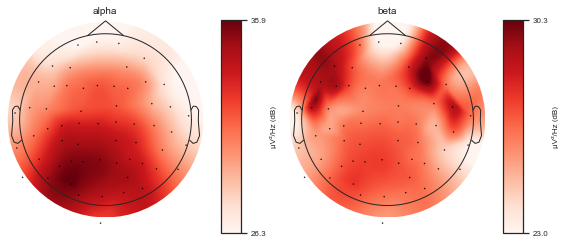

In [3]:
# Define frequency bands (alpha and beta)
bands = [(8, 12, 'alpha'), (12, 30, 'beta')]

# Extract epochs
LV = epochs['left visual'].copy()
RV = epochs['right visual'].copy()

# Iteratively plot
print('left visual stimuli')
fig, axes = plt.subplots(1,2,figsize=(8,4))
LV.plot_psd_topomap(bands, axes=axes, verbose=False);

print('right visual stimuli')
fig, axes = plt.subplots(1,2,figsize=(8,4))
RV.plot_psd_topomap(bands, axes=axes, verbose=False);

### Time-frequency analysis

In this section, we will apply spectral decomposition to the visual evoked potentials from previous notebook. Specifically, we will use Morlet wavelet decomposition to study the time-frequency composition of the evoked potentials.

First we need to define the parameters of the Morlet wavelet decomposition. This includes:

- `freqs`: frequencies of interest
- `n_cycles`: the number of cycles used for estimation, either globally or for each frequency

In [4]:
# Define parameters for wavelet
freqs = np.logspace(np.log(8), np.log(30), num=10, base=np.e) # Logarithmic sampling
n_cycles = 3

Next we will perform the decomposition for each condition separately.

In [5]:
from mne.time_frequency import tfr_morlet

# Extract epochs
LV = epochs['left visual'].copy()
RV = epochs['right visual'].copy()

# Perform time-frequency decomposition
LV_power = tfr_morlet(LV, freqs, n_cycles, average=True,
                      return_itc=False, verbose=False)
RV_power = tfr_morlet(RV, freqs, n_cycles, average=True,
                      return_itc=False, verbose=False)

It is important to perform baseline correction for time-frequency data. There are many methods for performing baseline correction. Here we will use the log-ratio technique:

$$ \text{decibel power} = 10 \times \log_{10}{\frac{\text{power}}{\text{baseline}}} $$

In [6]:
# Define baseline parameters
baseline = (-0.150, -0.050)
method = 'logratio'

# Apply baseline correction
LV_power = LV_power.apply_baseline(baseline, 'logratio')
RV_power = RV_power.apply_baseline(baseline, 'logratio')

# Convert to decibels
LV_power_arr = 10 * LV_power.data
RV_power_arr = 10 * RV_power.data

Applying baseline correction (mode: logratio)
Applying baseline correction (mode: logratio)


Similar to ERP analysis, we can plot out the difference between conditions across the entire scalp.

No baseline correction applied


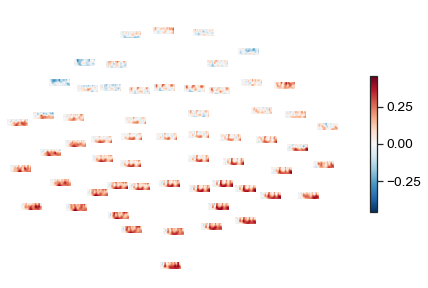

In [7]:
# Compute difference between conditions
averageTFR = RV_power - LV_power

# Plot topographic difference
averageTFR.plot_topo(baseline=None, fig_facecolor='w',
                     font_color='k', border='k');

Now let's visualize the difference between the right and left visual stimulus presentation for a left posterior channel, EEG 057.

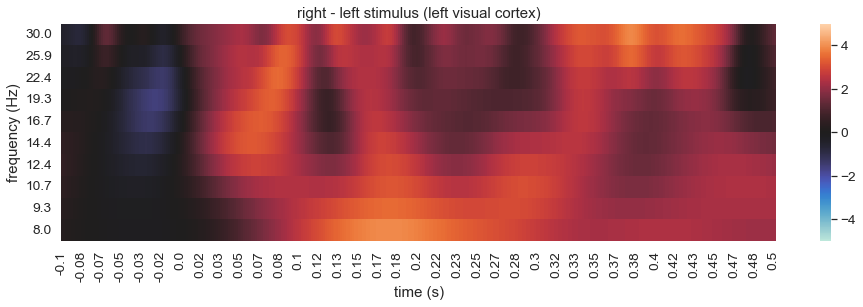

In [8]:
# Compute difference for EEG 057
diff = RV_power_arr[epochs.ch_names.index('EEG 057')] - LV_power_arr[epochs.ch_names.index('EEG 057')]

# Plot time-frequency
fig, ax = plt.subplots(1,1,figsize=(16,4))
sns.heatmap(diff, center=0, vmin=-5, vmax=5, yticklabels=freqs.round(1), ax=ax)
ax.set(xticks=np.arange(epochs.times.size)[::10], xticklabels=epochs.times[::10].round(2),
       xlabel='time (s)', ylabel='frequency (Hz)', title='right - left stimulus (left visual cortex)')
ax.invert_yaxis()

### Phase-locked vs. induced power
To compute nonphase-locked power (also sometimes called "induced" activity), we must subtract the event-related potential (ERP) from single trials.

In [9]:
from mne.time_frequency import tfr_morlet

# Extract epochs
LV = epochs['left visual'].copy()
RV = epochs['right visual'].copy()

# Subtract evoked potentials
LV = LV.subtract_evoked()
RV = RV.subtract_evoked()

# Perform time-frequency decomposition
LV_power = tfr_morlet(LV, freqs, n_cycles, average=True, return_itc=False, verbose=False)
RV_power = tfr_morlet(RV, freqs, n_cycles, average=True, return_itc=False, verbose=False)

Subtracting Evoked from Epochs
Removing projector <Projection | PCA-v1, active : True, n_channels : 102>
Removing projector <Projection | PCA-v2, active : True, n_channels : 102>
Removing projector <Projection | PCA-v3, active : True, n_channels : 102>
No projector specified for this dataset. Please consider the method self.add_proj.
[done]
Subtracting Evoked from Epochs
Removing projector <Projection | PCA-v1, active : True, n_channels : 102>
Removing projector <Projection | PCA-v2, active : True, n_channels : 102>
Removing projector <Projection | PCA-v3, active : True, n_channels : 102>
No projector specified for this dataset. Please consider the method self.add_proj.
[done]


In [10]:
# Define parameters for baseline correction
baseline = (-0.150, -0.050)
method = 'logratio'

# Apply baseline correction
LV_power = LV_power.apply_baseline(baseline, 'logratio')
RV_power = RV_power.apply_baseline(baseline, 'logratio')

# Convert to decibels
LV_power_arr = 10 * LV_power.data
RV_power_arr = 10 * RV_power.data

Applying baseline correction (mode: logratio)
Applying baseline correction (mode: logratio)


Now let's visualize the difference between the right and left visual stimulus presentation for a left posterior channel, EEG 057.

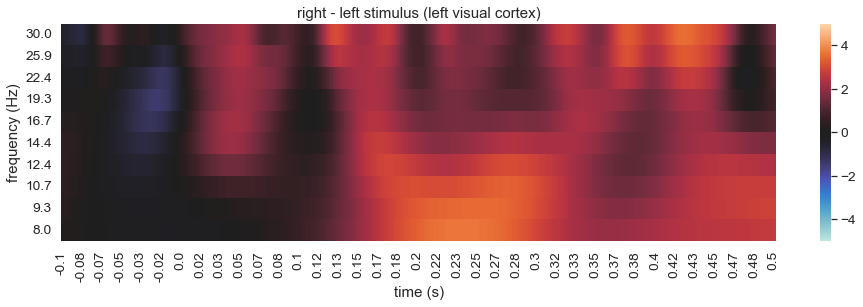

In [11]:
# Compute difference between left and right
diff = RV_power_arr[epochs.ch_names.index('EEG 057')] - LV_power_arr[epochs.ch_names.index('EEG 057')]

# Plotting induced power
fig, ax = plt.subplots(1,1,figsize=(16,4))
sns.heatmap(diff, center=0, vmin=-5, vmax=5, yticklabels=freqs.round(1), ax=ax)
ax.set(xticks=np.arange(epochs.times.size)[::10], xticklabels=epochs.times[::10].round(2),
       xlabel='time (s)', ylabel='frequency (Hz)', title='right - left stimulus (left visual cortex)')
ax.invert_yaxis()

### Permutation Testing

Finally, we demonstrate 2D time-frequency permutation testing. For a permutation test, we compute our statistics at the trial level. As such, we re-decompose our data at the trial level.

In [12]:
from mne.time_frequency import tfr_morlet

# Extract epochs
LV = epochs['left visual'].copy()
RV = epochs['right visual'].copy()

# Subtract evoked potential
LV = LV.subtract_evoked()
RV = RV.subtract_evoked()

# Perform time-frequency decomposition
LV_power = tfr_morlet(LV, freqs, n_cycles, average=False,
                      return_itc=False, verbose=False)
RV_power = tfr_morlet(RV, freqs, n_cycles, average=False,
                      return_itc=False, verbose=False)

# Apply baseline correction
LV_power = LV_power.apply_baseline((-0.150, -0.050), 'logratio')
RV_power = RV_power.apply_baseline((-0.150, -0.050), 'logratio')

# Convert to decibels
LV_power_arr = 10 * LV_power.data
RV_power_arr = 10 * RV_power.data

Subtracting Evoked from Epochs
Removing projector <Projection | PCA-v1, active : True, n_channels : 102>
Removing projector <Projection | PCA-v2, active : True, n_channels : 102>
Removing projector <Projection | PCA-v3, active : True, n_channels : 102>
No projector specified for this dataset. Please consider the method self.add_proj.
[done]
Subtracting Evoked from Epochs
Removing projector <Projection | PCA-v1, active : True, n_channels : 102>
Removing projector <Projection | PCA-v2, active : True, n_channels : 102>
Removing projector <Projection | PCA-v3, active : True, n_channels : 102>
No projector specified for this dataset. Please consider the method self.add_proj.
[done]
Applying baseline correction (mode: logratio)
Applying baseline correction (mode: logratio)


Now let's perform permutation testing. We above, we restrict our analysis to our channel of interest. We then pass both arrays, as a list, to `mne.stats.permutation_cluster_test`.

In [13]:
from mne.stats import permutation_cluster_test

# Limit to channel of interest (EEG 057)
ix = epochs.ch_names.index('EEG 057')
LV_power_057 = LV_power_arr[ix]
RV_power_057 = RV_power_arr[ix]

# Perform permutation testing
F_obs, clusters, cluster_pv, H0 = permutation_cluster_test([RV_power_057, LV_power_057], 
                                                           n_permutations=1001,
                                                           out_type='mask')

Using a threshold of 3.922879
stat_fun(H1): min=0.000004 max=78.401614
Running initial clustering
Found 19 clusters
Permuting 1000 times...


/var/folders/ch/f_vp72713hg84pcp6t_2wfmw0000gp/T/ipykernel_4190/1716487633.py:9: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  F_obs, clusters, cluster_pv, H0 = permutation_cluster_test([RV_power_057, LV_power_057],


  0%|          |  : 0/1000 [00:00<?,       ?it/s]

Computing cluster p-values
Done.


First let's visualize the clusters the permutation test detected.

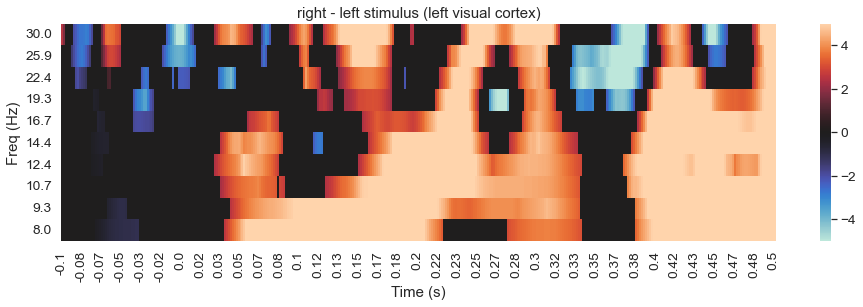

In [14]:
# Compute difference
diff = RV_power_057.mean(axis=0) - LV_power_057.mean(axis=0)
diff *= np.sum(clusters, axis=0)

# Plotting clusters
fig, ax = plt.subplots(1,1,figsize=(16,4))
sns.heatmap(diff, center=0, vmin=-5, vmax=5, yticklabels=freqs.round(1), ax=ax)
ax.set(xticks=np.arange(epochs.times.size)[::10], xticklabels=epochs.times[::10].round(2),
       xlabel='Time (s)', ylabel='Freq (Hz)', title='right - left stimulus (left visual cortex)')
ax.invert_yaxis()

Now let's threshold to only the significant clusters.

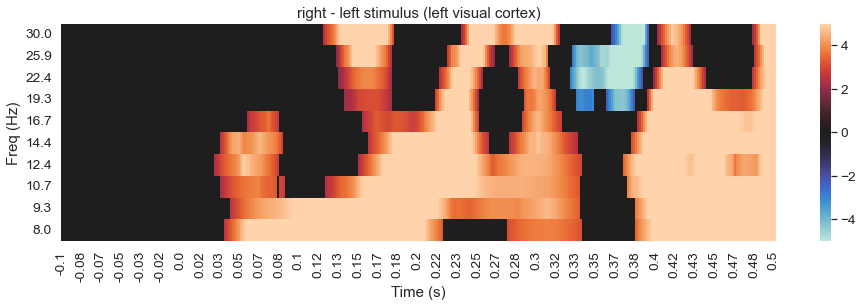

In [15]:
# Compute difference
diff = diff = RV_power_057.mean(axis=0) - LV_power_057.mean(axis=0)
diff *= np.sum([cluster if p < 0.05 else np.zeros_like(cluster) 
                for p, cluster in zip(cluster_pv, clusters)], axis=0)

## Plotting.
fig, ax = plt.subplots(1,1,figsize=(16,4))
sns.heatmap(diff, center=0, vmin=-5, vmax=5, yticklabels=freqs.round(1), ax=ax)
ax.set(xticks=np.arange(epochs.times.size)[::10], xticklabels=epochs.times[::10].round(2),
       xlabel='Time (s)', ylabel='Freq (Hz)', title='right - left stimulus (left visual cortex)')
ax.invert_yaxis()